In [1]:
!pip install mne==1.7.1
!pip install PyWavelets
!pip install scipy

In [2]:
import mne
import numpy as np
import pandas as pd
import pywt
from pywt import wavedec
import scipy.stats as stats

In [3]:
raw = mne.io.read_raw_edf("1-2.edf", preload=True)
print(raw.info)

Extracting EDF parameters from /home/xilinx/jupyter_notebooks/VHDL_linear_algebra/DWT/1-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ...   599.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


In [4]:
# Sélectionner les 5 premiers canaux EEG
#r=raw.pick_channels(raw.ch_names[:5])

Using matplotlib as 2D backend.


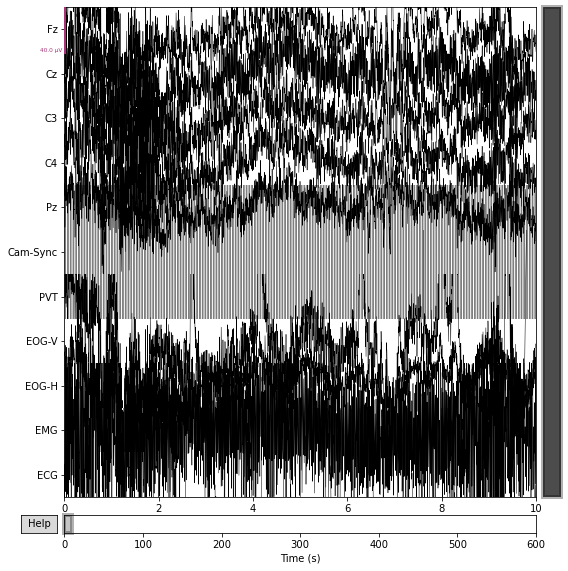

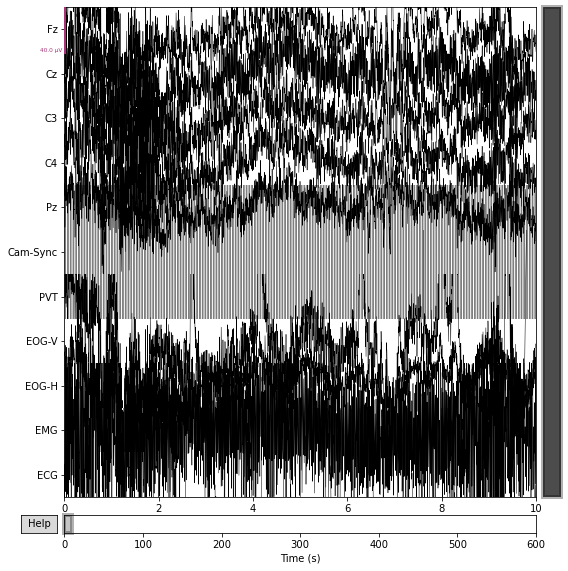

In [5]:
raw.plot()

In [6]:
%%time
rf = raw.filter(0.1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)

CPU times: user 6.18 s, sys: 862 ms, total: 7.05 s
Wall time: 7.04 s


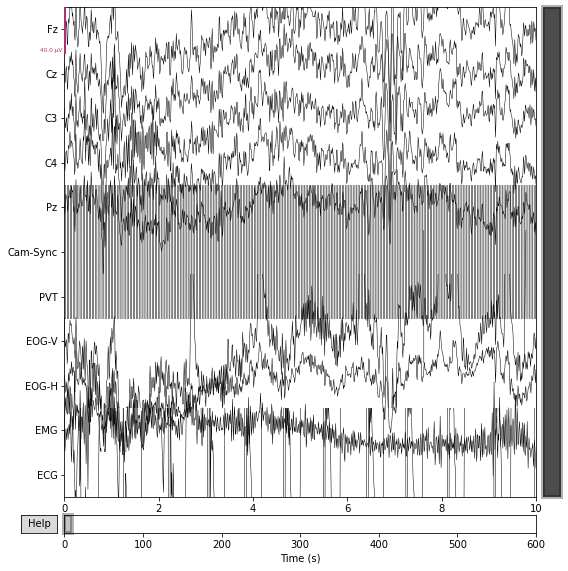

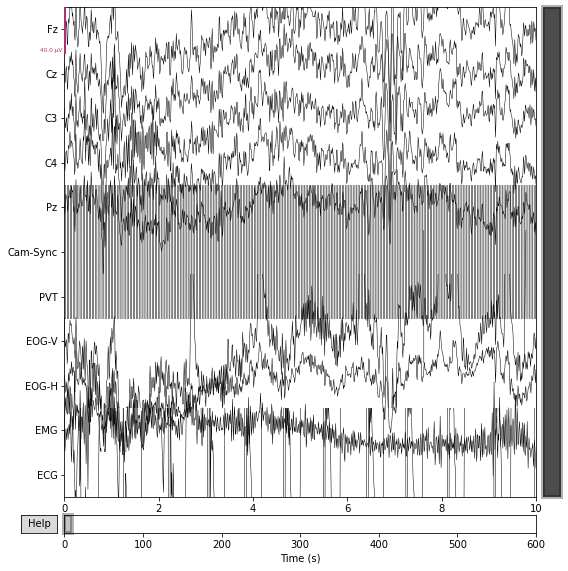

In [7]:
rf.plot()

In [8]:
print(rf.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


In [9]:
selected_channel_name = rf.info['ch_names']
sample_frequency = rf.info['sfreq']
epoch_duration = 10

In [10]:
selected_channel_name

['Fz',
 'Cz',
 'C3',
 'C4',
 'Pz',
 'Cam-Sync',
 'PVT',
 'EOG-V',
 'EOG-H',
 'EMG',
 'ECG']

In [11]:
sample_frequency

512.0

In [12]:
epoch_samples = int(epoch_duration*sample_frequency)

In [13]:
epoch_samples

5120

In [14]:
total_epochs = 307200// epoch_samples

In [15]:
total_epochs

60

In [16]:
epochs_matrix = np.zeros((total_epochs, 5, epoch_samples))  # 5 channels

In [17]:
# Segmenter les données en epochs de 10 secondes
events = mne.make_fixed_length_events(rf, duration=epoch_duration)

In [18]:
# Créer un objet Epochs
epochs = mne.Epochs(rf, events, tmin=0, tmax=epoch_duration, baseline=None, detrend=1)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [19]:
# Obtenir les données des epochs sous forme de tableau numpy
epochs_data = epochs.get_data()

Using data from preloaded Raw for 60 events and 5121 original time points ...
1 bad epochs dropped


In [20]:
# Vérifier la forme de la matrice d'epochs
print("Forme de la matrice d'epochs:", epochs_data.shape)

Forme de la matrice d'epochs: (59, 11, 5121)


In [21]:
zscores = stats.zscore(epochs_data)

In [22]:
zscores.shape

(59, 11, 5121)

In [23]:
# Définition de la famille d'ondelettes à utiliser
wavelet = 'db4'

# Initialisation des tableaux pour stocker les caractéristiques
cD_Energy = np.zeros((59, 5))
cA_Energy = np.zeros((59, 5))
D_Entropy = np.zeros((59, 5))
A_Entropy = np.zeros((59, 5))
D_mean = np.zeros((59, 5))
A_mean = np.zeros((59, 5))
D_std = np.zeros((59, 5))
A_std = np.zeros((59, 5))

In [24]:
import time

In [25]:
%%time

input_buffer = [i for i in range(len(zscores[0, 0, :]))]

data_time = 0.0
process_time = 0.0
reduce_time = 0.0

for i in range(59):
  for j in range(5):
    #input_buffer[0:len(input_buffer)] = zscores[i, j, :]
    start_time = time.time()
    input_buffer = zscores[i, j, :]
    data_time += time.time() - start_time
    
#    coeffs = pywt.wavedec(zscores[i, j, :], wavelet, mode='symmetric', level=5, axis=0)  # Calcul de la DWT avec pywt
    
    start_time = time.time()
    coeffs = pywt.wavedec(input_buffer, wavelet, mode='symmetric', level=5, axis=0)  # Calcul de la DWT avec pywt
    process_time += time.time() - start_time
    
    start_time = time.time()
    cD_Energy[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy[i,j] = np.sum(np.square(coeffs[0]))
    D_Entropy[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    A_Entropy[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    A_mean[i,j] = np.mean(coeffs[0])
    D_std[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    A_std[i,j] = np.std(coeffs[0])
    reduce_time += time.time() - start_time
    
print("total_time: ", data_time + process_time + reduce_time)
print("data_time: ", data_time)
print("process_time: ", process_time)
print("reduce_time: ", reduce_time)

total_time:  3.182528018951416
data_time:  0.006135225296020508
process_time:  0.6522133350372314
reduce_time:  2.524179458618164
CPU times: user 3.19 s, sys: 7.96 ms, total: 3.19 s
Wall time: 3.19 s


### FPGA implementation part

In [34]:
import numpy as np
import time
import struct

from pynq import Overlay
from pynq import allocate
from pynq import PL

PL.reset()

#overlay = Overlay('yuv_filter_full.bit')
overlay = Overlay('design_9.bit')

# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

reducer     = overlay.reducer_0
dwt_db4_hls = overlay.dwt_db4_hls_0

dma_data_in = overlay.axi_dma_data_in
dma_data_in_send = overlay.axi_dma_data_in.sendchannel

dma_coeff_lo = overlay.axi_dma_coeff_lo
dma_coeff_lo_recv = overlay.axi_dma_coeff_lo.recvchannel

dma_coeff_hi = overlay.axi_dma_coeff_hi
dma_coeff_hi_recv = overlay.axi_dma_coeff_hi.recvchannel

dma_reduce_in = overlay.axi_dma_reduce_in
dma_reduce_in_send = overlay.axi_dma_reduce_in.sendchannel

#Get register offset of my parameter
def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

DWT_SIZE_REGISTER = get_register_offset(overlay, 'dwt_db4_hls_0', 'size')
print('DWT_SIZE_REGISTER =', hex(DWT_SIZE_REGISTER))

DEBUG_REGISTER = get_register_offset(overlay, 'dwt_db4_hls_0', 'debug')
print('DEBUG_REGISTER =', hex(DEBUG_REGISTER))

RED_SIZE_REGISTER = get_register_offset(overlay, 'reducer_0', 'size')
print('RED_SIZE_REGISTER =', hex(RED_SIZE_REGISTER))

SQUARE_SUM_REGISTER = get_register_offset(overlay, 'reducer_0', 'square_sum')
print('SQUARE_SUM_REGISTER =', hex(SQUARE_SUM_REGISTER))

MEAN_REGISTER = get_register_offset(overlay, 'reducer_0', 'mean')
print('MEAN_REGISTER =', hex(MEAN_REGISTER))

STD_REGISTER = get_register_offset(overlay, 'reducer_0', 'std')
print('STD_REGISTER =', hex(STD_REGISTER))

ENTROPY_REGISTER = get_register_offset(overlay, 'reducer_0', 'entropy')
print('ENTROPY_REGISTER =', hex(ENTROPY_REGISTER))


#Start my IPs

CONTROL_REGISTER = 0x0
#dwt_db4_hls.write(CONTROL_REGISTER, 0x81)


def print_dma_data(dma_channel):
    print("error: ", dma_channel.error, " idle: ", dma_channel.idle, " running: ", dma_channel.running)


#Data transfer to DMAs
def dma_transfer(input_buffer, lo_buffer, hi_buffer):
    dma_data_in_send.transfer(input_buffer)    
    dma_coeff_lo_recv.transfer(lo_buffer)  
    dma_coeff_hi_recv.transfer(hi_buffer)  
    dma_data_in_send.wait()
    dma_coeff_lo_recv.wait()
    dma_coeff_hi_recv.wait()

def process_data(in_buffer, lo_buffer, hi_buffer):
    size = len(in_buffer)
    #print(size)
    #print("debug 1 ", dwt_db4_hls.read(DEBUG_REGISTER))
    #dwt_db4_hls.register_map.size = size
    #dwt_db4_hls.register_map.CRTL.AP_START = 1
    dwt_db4_hls.write(DWT_SIZE_REGISTER, size)
    dwt_db4_hls.write(CONTROL_REGISTER, 0x01)
    #print("debug 2 ", dwt_db4_hls.read(DEBUG_REGISTER))
    dma_transfer(in_buffer, lo_buffer, hi_buffer)
    #print("debug 3 ", dwt_db4_hls.read(DEBUG_REGISTER))
    #dwt_db4_hls.write(CONTROL_REGISTER, 0x00)

def reduce_data(coeff_data):
    size = len(coeff_data)
    reducer.write(RED_SIZE_REGISTER, size)
    reducer.write(CONTROL_REGISTER, 0x01)
    dma_reduce_in_send.transfer(coeff_data)    
    dma_reduce_in_send.wait()
    #square_sum = reducer.read(SQUARE_SUM_REGISTER)
    #mean = reducer.read(MEAN_REGISTER)
    #std = reducer.read(STD_REGISTER)
    #entropy = reducer.read(ENTROPY_REGISTER)
    square_sum = struct.unpack('f', struct.pack('I', reducer.read(SQUARE_SUM_REGISTER)))[0]
    mean = struct.unpack('f', struct.pack('I', reducer.read(MEAN_REGISTER)))[0]
    std = struct.unpack('f', struct.pack('I', reducer.read(STD_REGISTER)))[0]
    entropy = struct.unpack('f', struct.pack('I', reducer.read(ENTROPY_REGISTER)))[0]
    return [square_sum, mean, std, entropy]
    

IP blocks : ['dwt_db4_hls_0', 'reducer_0', 'axi_dma_data_in', 'axi_dma_coeff_lo', 'axi_dma_coeff_hi', 'axi_dma_reduce_in', 'processing_system7_0']
DWT_SIZE_REGISTER = 0x18
DEBUG_REGISTER = 0x20
RED_SIZE_REGISTER = 0x58
SQUARE_SUM_REGISTER = 0x18
MEAN_REGISTER = 0x28
STD_REGISTER = 0x38
ENTROPY_REGISTER = 0x48


In [35]:
#test hardware
#in_data = [float(i) for i in range(32)]

#approx_coeff_data, detail_1_coeff_data, detail_2_coeff_data, detail_3_coeff_data, detail_4_coeff_data, detail_5_coeff_data = process_data(in_data)

#print("in data: ", in_data)
#print("approx coeff data: ", approx_coeff_data)
#print("detail coeff 5 data: ", detail_5_coeff_data)
#print("detail coeff 4 data: ", detail_4_coeff_data)
#print("detail coeff 3 data: ", detail_3_coeff_data)
#print("detail coeff 2 data: ", detail_2_coeff_data)
#print("detail coeff 1 data: ", detail_1_coeff_data)

In [36]:
cD_Energy_pynq = np.zeros((59, 5))
cA_Energy_pynq = np.zeros((59, 5))
D_Entropy_pynq = np.zeros((59, 5))
A_Entropy_pynq = np.zeros((59, 5))
D_mean_pynq = np.zeros((59, 5))
A_mean_pynq = np.zeros((59, 5))
D_std_pynq = np.zeros((59, 5))
A_std_pynq = np.zeros((59, 5))

In [37]:
%%time

#create buffers
data_in_size = len(zscores[0, 0, :])
data_1_size = int((data_in_size + 8 - 1) / 2)
data_2_size = int((data_1_size + 8 - 1) / 2)
data_3_size = int((data_2_size + 8 - 1) / 2)
data_4_size = int((data_3_size + 8 - 1) / 2)
data_5_size = int((data_4_size + 8 - 1) / 2)
print(data_in_size)
print(data_1_size)
print(data_2_size)
print(data_3_size)
print(data_4_size)
print(data_5_size)

input_buffer = allocate(shape=(data_in_size,), dtype=np.float32)
lo_1_buffer = allocate(shape=(data_1_size,), dtype=np.float32)
lo_2_buffer = allocate(shape=(data_2_size,), dtype=np.float32)
lo_3_buffer = allocate(shape=(data_3_size,), dtype=np.float32)
lo_4_buffer = allocate(shape=(data_4_size,), dtype=np.float32)
lo_5_buffer = allocate(shape=(data_5_size,), dtype=np.float32)
hi_1_buffer = allocate(shape=(data_1_size,), dtype=np.float32)
hi_2_buffer = allocate(shape=(data_2_size,), dtype=np.float32)
hi_3_buffer = allocate(shape=(data_3_size,), dtype=np.float32)
hi_4_buffer = allocate(shape=(data_4_size,), dtype=np.float32)
hi_5_buffer = allocate(shape=(data_5_size,), dtype=np.float32)

data_time_list = []
control_time_list = []
process_time_list = []

data_time = 0.0
process_time = 0.0
reduce_time = 0.0

for i in range(59):
  for j in range(5):
    start_time = time.time()
    input_buffer[0:len(zscores[i, j, :])] = zscores[i, j, :]
    data_time += time.time() - start_time
    
    start_time = time.time()
    process_data(input_buffer, lo_1_buffer, hi_1_buffer)
    process_data(lo_1_buffer,  lo_2_buffer, hi_2_buffer)
    process_data(lo_2_buffer,  lo_3_buffer, hi_3_buffer)
    process_data(lo_3_buffer,  lo_4_buffer, hi_4_buffer)
    process_data(lo_4_buffer,  lo_5_buffer, hi_5_buffer)
    process_time += time.time() - start_time
    
    start_time = time.time()
    
    squared_sum_0, mean_0, std_0, entropy_0 = reduce_data(lo_5_buffer)
    squared_sum_1, mean_1, std_1, entropy_1 = reduce_data(hi_1_buffer)
    squared_sum_2, mean_2, std_2, entropy_2 = reduce_data(hi_2_buffer)
    squared_sum_3, mean_3, std_3, entropy_3 = reduce_data(hi_3_buffer)
    squared_sum_4, mean_4, std_4, entropy_4 = reduce_data(hi_4_buffer)
    squared_sum_5, mean_5, std_5, entropy_5 = reduce_data(hi_5_buffer)

    cD_Energy_pynq[i,j] = (squared_sum_1 + squared_sum_2 + squared_sum_3 + squared_sum_4 + squared_sum_5)/5
    cA_Energy_pynq[i,j] = squared_sum_0
    D_Entropy_pynq[i,j] = (entropy_1 + entropy_2 + entropy_3 + entropy_4 + entropy_5)/4
    A_Entropy_pynq[i,j] = entropy_0
    D_mean_pynq[i,j]    = (mean_1 + mean_2 + mean_3 + mean_4 + mean_5)/5
    A_mean_pynq[i,j]    = mean_0
    D_std_pynq[i,j]    = (std_1 + std_2 + std_3 + std_4 + std_5)/5
    A_std_pynq[i,j]    = std_0
    
    #coeffs = [lo_5_buffer, hi_1_buffer, hi_2_buffer, hi_3_buffer, hi_4_buffer, hi_5_buffer]
    #cD_Energy_pynq[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
    #                     np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
    #                     np.sum(np.square(coeffs[1]))])
    #cA_Energy_pynq[i,j] = np.sum(np.square(coeffs[0]))
    #D_Entropy_pynq[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
    #                     np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
    #                     np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
    #                     np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
    #                     np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    #A_Entropy_pynq[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    #D_mean_pynq[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    #A_mean_pynq[i,j] = np.mean(coeffs[0])
    #D_std_pynq[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    #A_std_pynq[i,j] = np.std(coeffs[0])
    reduce_time += time.time() - start_time


print("total_time: ", data_time + process_time + reduce_time)
print("data_time: ", data_time)
print("process_time: ", process_time)
print("reduce_time: ", reduce_time)

#release buffers
del input_buffer, lo_1_buffer, lo_2_buffer, lo_3_buffer, lo_4_buffer, lo_5_buffer, hi_1_buffer, hi_2_buffer, hi_3_buffer, hi_4_buffer, hi_5_buffer

5121
2564
1285
646
326
166
total_time:  2.8797402381896973
data_time:  0.09252595901489258
process_time:  1.7752618789672852
reduce_time:  1.0119524002075195
CPU times: user 2.87 s, sys: 39 ms, total: 2.91 s
Wall time: 2.91 s


In [38]:
print(cA_Energy[0,0], cA_Energy_pynq[0,0])
print(cA_Energy[0,0], cA_Energy_pynq[0,0])
print(D_Entropy[0,0], D_Entropy_pynq[0,0])
print(A_Entropy[0,0], A_Entropy_pynq[0,0])
print(D_mean[0,0], D_mean_pynq[0,0])
print(A_mean[0,0], A_mean_pynq[0,0])
print(D_std[0,0], D_std_pynq[0,0])
print(A_std[0,0], A_std_pynq[0,0])

6193.220549783609 6193.2197265625
6193.220549783609 6193.2197265625
258.07067688703876 322.58828887715936
27665.834187823406 27665.828125
-0.008345087078333107 0.09001831002533436
0.2484968867229064 0.24849683046340942
0.6236392446913396 0.0
6.10301620726227 0.0


In [31]:
df = pd.DataFrame(cD_Energy)
df1 = pd.DataFrame(cA_Energy)
df2 = pd.DataFrame(D_Entropy)
df3 = pd.DataFrame(A_Entropy)
df4 = pd.DataFrame(D_mean)
df5 = pd.DataFrame(A_mean)
df6 = pd.DataFrame(D_std)
df7 = pd.DataFrame(A_std)

In [32]:
ddd = pd.concat([df,df1,df2,df3,df4,df5,df6,df7], axis = 1)

In [33]:
ddd

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,183.118223,211.603349,311.911682,234.526123,203.051072,6193.220550,6035.926952,6396.474672,5359.695028,4193.920525,...,0.623639,0.672596,0.804787,0.707285,0.655354,6.103016,6.030003,6.206866,5.680175,5.025439
1,117.089863,145.328197,170.362660,147.025249,135.630733,2940.678914,2600.932622,2325.618785,2136.261727,2536.933035,...,0.497830,0.555181,0.600777,0.558953,0.538374,4.201039,3.938294,3.736173,3.573627,3.889780
2,127.493412,150.443574,152.556108,133.232314,145.362897,2549.984843,2705.129055,2523.578279,2073.822671,2517.612931,...,0.516086,0.560285,0.568144,0.528069,0.551250,3.918648,4.036276,3.897274,3.534526,3.893299
3,137.524497,207.542447,211.825710,168.156876,186.205038,4048.478566,3939.092900,3305.893763,3573.566587,3209.275013,...,0.538250,0.658902,0.667718,0.596381,0.623092,4.921764,4.848606,4.445989,4.608401,4.383951
4,105.235156,156.651562,144.299604,174.088952,196.515161,2577.000776,2143.527191,2147.359371,2393.012222,2465.600950,...,0.471363,0.573393,0.552839,0.603761,0.640522,3.939675,3.587577,3.590768,3.786757,3.848696
5,148.889636,202.217887,206.578001,204.100180,229.638194,2576.182600,2363.601893,2147.941392,2035.612923,2671.577562,...,0.563315,0.654155,0.663274,0.659629,0.697673,3.937962,3.771937,3.596892,3.501056,4.011551
6,177.426605,243.611904,201.961706,246.757855,277.973275,6136.551686,4419.925678,5696.795464,4648.147875,3952.291159,...,0.614562,0.720129,0.659337,0.725537,0.767871,6.078897,5.159314,5.856055,5.291482,4.878565
7,218.369107,296.961087,289.588507,291.092229,331.177627,2371.994738,2821.904064,2404.167831,2354.779318,3007.939539,...,0.677656,0.790321,0.782852,0.783012,0.827907,3.780094,4.123031,3.805181,3.763382,4.256349
8,260.794231,376.417465,282.394473,316.774522,433.073111,3274.250994,2551.306172,2603.821017,2246.043004,3206.765353,...,0.735060,0.885441,0.773327,0.814684,0.936157,4.438030,3.918583,3.956470,3.678234,4.394055
9,255.020025,319.953985,272.963142,303.721562,364.177175,6767.526030,5895.335615,5878.072107,5469.358206,5704.938103,...,0.727743,0.814580,0.758546,0.796426,0.865172,6.384088,5.954139,5.950465,5.734649,5.838779
